# 05. Custom Model Training & Hyperparameter Tuning

**Authors:** CloudAikes Team  
**Purpose:** Train and tune custom XGBoost model with comprehensive evaluation

---

In deze notebook trainen we een custom XGBoost model met volledige controle over hyperparameters. XGBoost wordt vaak gebruikt in Kaggle competitions omdat het zeer goed presteert op structured/tabular data. We vergelijken een baseline XGBoost met een getuned versie via RandomizedSearchCV. Dit geeft ons meer inzicht dan PyCaret's black box aanpak.

## 1. Setup & Imports

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
from datetime import datetime
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# XGBoost
try:
    import xgboost as xgb
    print(f"✅ XGBoost version: {xgb.__version__}")
except ImportError:
    print("⚠️  XGBoost not installed. Run: pip install xgboost")

# LightGBM (alternative)
try:
    import lightgbm as lgb
    print(f"✅ LightGBM version: {lgb.__version__}")
except ImportError:
    print("⚠️  LightGBM not installed. Run: pip install lightgbm")

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

print("\n✅ All libraries imported successfully!")

✅ XGBoost version: 3.1.1
✅ LightGBM version: 4.6.0

✅ All libraries imported successfully!


We importeren XGBoost en LightGBM (beiden gradient boosting libraries). XGBoost is vaak iets accurater, LightGBM is sneller bij grote datasets. Voor deze notebook focussen we op XGBoost. De sklearn imports zijn voor train/test split, metrics, en hyperparameter tuning via GridSearchCV/RandomizedSearchCV.

## 2. Data Loading & Preparation

In [3]:
# Load cleaned data
data_file = Path('../data/processed/demand_data_cleaned.csv')
if data_file.exists():
    df = pd.read_csv(data_file)
    print(f"✅ Loaded data: {df.shape[0]} rows x {df.shape[1]} columns")
else:
    print("⚠️  Run notebook 02 first to create cleaned data")

# Show data info
print("\n📊 Dataset shape:", df.shape)
print("\n📋 Columns:", df.columns.tolist())

✅ Loaded data: 434014 rows x 31 columns

📊 Dataset shape: (434014, 31)

📋 Columns: ['settlement_date', 'settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow', 'year', 'month', 'day', 'dayofweek', 'quarter', 'week', 'hour', 'day_name', 'is_weekend']


In [4]:
print("\n🔧 Preparing features...")

# Define target
target = 'nd'  # National Demand

# Features to drop based on analysis from notebook 03b
drop_cols = [
    target,
    'settlement_date',  # Date column (already extracted features)
    'tsd',  # Too correlated with target (transmission system demand)
    'england_wales_demand',  # Highly correlated with target
    'day_name',  # Redundant (have dayofweek)
    'hour',  # Redundant with settlement_period
    'quarter', 
]

# Remove columns that don't exist
drop_cols = [col for col in drop_cols if col in df.columns]

# Prepare X and y
y = df[target]
X = df.drop(columns=drop_cols)

print(f"\n✅ Target: {target}")
print(f"✅ Features: {X.shape[1]} columns")
print(f"✅ Dropped: {drop_cols}")
print(f"\n📋 Selected features:\n{X.columns.tolist()}")


🔧 Preparing features...

✅ Target: nd
✅ Features: 24 columns
✅ Dropped: ['nd', 'settlement_date', 'tsd', 'england_wales_demand', 'day_name', 'hour', 'quarter']

📋 Selected features:
['settlement_period', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow', 'year', 'month', 'day', 'dayofweek', 'week', 'is_weekend']


Feature selection gebaseerd op notebook 03b (correlation analysis):
- **Verwijderd**: `england_wales_demand` (data leakage), `tsd` (te gecorreleerd), `hour` (redundant met settlement_period), `quarter` (redundant met month)
- **Behouden**: 24 features inclusief temporele features, embedded generation, interconnectors, en grid operations

Dit is een cleanere feature set dan in eerdere notebooks - we hebben de lessen uit de correlation analysis toegepast.

In [5]:
# Time-series aware split (use last 20% as test)
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"✅ Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"✅ Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

✅ Train set: 347211 samples (80.0%)
✅ Test set: 86803 samples (20.0%)


Hier gebruiken we een **temporele split** in plaats van random split zoals in notebooks 03 en 04. De eerste 80% (chronologisch) is training, laatste 20% is test. Dit is realistischer voor tijdreeksdata omdat het simuleert hoe het model in productie gebruikt wordt: trainen op historische data, voorspellen op toekomstige data. Performance kan lager zijn dan bij random split.

## 3. Baseline XGBoost Model

In [6]:
print("\n🚀 Training baseline XGBoost model...\n")

# Initialize baseline model with reasonable defaults
xgb_baseline = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Train
xgb_baseline.fit(X_train, y_train)

# Predictions
y_train_pred_baseline = xgb_baseline.predict(X_train)
y_test_pred_baseline = xgb_baseline.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Metrics:")
    print(f"  MSE:  {mse:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAE:  {mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

baseline_train_metrics = calculate_metrics(y_train, y_train_pred_baseline, "TRAIN")
baseline_test_metrics = calculate_metrics(y_test, y_test_pred_baseline, "TEST")

print("\n✅ Baseline XGBoost model trained!")


🚀 Training baseline XGBoost model...


TRAIN Metrics:
  MSE:  1,639,618.93
  RMSE: 1,280.48
  MAE:  941.03
  R²:   0.9757

TEST Metrics:
  MSE:  5,138,805.41
  RMSE: 2,266.89
  MAE:  1,764.00
  R²:   0.8665

✅ Baseline XGBoost model trained!


Baseline XGBoost met default parameters:
- Train RMSE: 1,280 MW (R² = 0.976)
- Test RMSE: 2,267 MW (R² = 0.867)

Vergelijkbaar met de Random Forest uit notebook 03 (test RMSE 2,732 MW). XGBoost is iets beter out-of-the-box. Het verschil tussen train en test duidt op overfitting - het model leert training data te goed. Hyperparameter tuning kan dit verbeteren door regularisatie parameters aan te passen.

## 4. Hyperparameter Tuning with GridSearchCV

In [7]:
print("\n🔧 Starting hyperparameter tuning...\n")
print("⏰ This may take 10-30 minutes depending on your hardware\n")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

print("📊 Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n🔢 Total combinations: {total_combinations:,}")
print("\n💡 Using RandomizedSearchCV to sample 50 combinations for efficiency\n")

# Use RandomizedSearchCV for efficiency (samples random combinations)
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit (this takes time!)
print("🏃 Starting training...\n")
random_search.fit(X_train, y_train)

print("\n✅ Hyperparameter tuning complete!")
print(f"\n🏆 Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best CV MSE: {-random_search.best_score_:,.2f}")
print(f"📊 Best CV RMSE: {np.sqrt(-random_search.best_score_):,.2f}")


🔧 Starting hyperparameter tuning...

⏰ This may take 10-30 minutes depending on your hardware

📊 Parameter grid:
  n_estimators: [100, 200, 300]
  max_depth: [3, 5, 7, 9]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  subsample: [0.8, 0.9, 1.0]
  colsample_bytree: [0.8, 0.9, 1.0]
  min_child_weight: [1, 3, 5]
  gamma: [0, 0.1, 0.2]

🔢 Total combinations: 3,888

💡 Using RandomizedSearchCV to sample 50 combinations for efficiency

🏃 Starting training...

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Hyperparameter tuning complete!

🏆 Best parameters found:
  subsample: 0.9
  n_estimators: 300
  min_child_weight: 5
  max_depth: 7
  learning_rate: 0.05
  gamma: 0.2
  colsample_bytree: 0.9

📊 Best CV MSE: 4,112,785.05
📊 Best CV RMSE: 2,028.00


RandomizedSearchCV test 50 random combinaties uit 3,888 mogelijke parameter combinaties. Dit is efficiënter dan GridSearchCV (die alle 3,888 zou testen). Beste parameters:
- `n_estimators=300`: meer trees = beter, maar trager
- `max_depth=7`: diepere trees kunnen complexere patronen leren
- `learning_rate=0.05`: lagere learning rate vereist meer trees maar generaliseert beter
- `subsample=0.9`, `colsample_bytree=0.9`: regularisatie via random sampling
- `gamma=0.2`: extra regularisatie om overfitting te verminderen

CV RMSE van 2,028 MW is beter dan baseline test RMSE (2,267 MW). De cross-validation gebruikt verschillende data splits voor robuustere evaluatie.

## 5. Evaluate Tuned Model

In [8]:
# Get best model
xgb_tuned = random_search.best_estimator_

# Predictions
y_train_pred_tuned = xgb_tuned.predict(X_train)
y_test_pred_tuned = xgb_tuned.predict(X_test)

# Calculate metrics
tuned_train_metrics = calculate_metrics(y_train, y_train_pred_tuned, "TUNED TRAIN")
tuned_test_metrics = calculate_metrics(y_test, y_test_pred_tuned, "TUNED TEST")

# Compare with baseline
print("\n" + "="*60)
print("📊 COMPARISON: Baseline vs Tuned Model")
print("="*60)

comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Baseline Test': [
        baseline_test_metrics['RMSE'],
        baseline_test_metrics['MAE'],
        baseline_test_metrics['R²']
    ],
    'Tuned Test': [
        tuned_test_metrics['RMSE'],
        tuned_test_metrics['MAE'],
        tuned_test_metrics['R²']
    ]
})

comparison_df['Improvement'] = [
    f"{((baseline_test_metrics['RMSE'] - tuned_test_metrics['RMSE']) / baseline_test_metrics['RMSE'] * 100):.2f}%",
    f"{((baseline_test_metrics['MAE'] - tuned_test_metrics['MAE']) / baseline_test_metrics['MAE'] * 100):.2f}%",
    f"{((tuned_test_metrics['R²'] - baseline_test_metrics['R²']) / baseline_test_metrics['R²'] * 100):.2f}%"
]

print("\n", comparison_df.to_string(index=False))
print("\n" + "="*60)


TUNED TRAIN Metrics:
  MSE:  932,164.50
  RMSE: 965.49
  MAE:  703.48
  R²:   0.9862

TUNED TEST Metrics:
  MSE:  5,012,592.20
  RMSE: 2,238.88
  MAE:  1,722.70
  R²:   0.8697

📊 COMPARISON: Baseline vs Tuned Model

 Metric  Baseline Test  Tuned Test Improvement
  RMSE    2266.893340 2238.881908       1.24%
   MAE    1763.999855 1722.696716       2.34%
    R²       0.866451    0.869731       0.38%



Tuned model performance:
- Train RMSE: 965 MW (R² = 0.986) - nog steeds overfitting maar minder erg
- Test RMSE: 2,239 MW (R² = 0.870)

**Verbetering vs baseline**: RMSE daalt met 1.24%, MAE met 2.34%. Dit lijkt klein maar op een RMSE van ~2,200 MW is 28 MW verbetering significant. De R² stijgt van 0.866 naar 0.870. Tuning heeft vooral de train performance verbeterd (965 vs 1,280 MW) terwijl test performance stabiel blijft - dit betekent minder overfitting door betere regularisatie.

## 6. Cross-Validation Analysis


🔄 Performing 5-fold cross-validation on tuned model...

📊 Cross-Validation RMSE Scores:
  Fold 1: 1,864.27
  Fold 2: 1,632.68
  Fold 3: 2,230.81
  Fold 4: 1,969.93
  Fold 5: 2,359.15

✅ Mean CV RMSE: 2,011.37 (+/- 518.36)
✅ Min CV RMSE:  1,632.68
✅ Max CV RMSE:  2,359.15


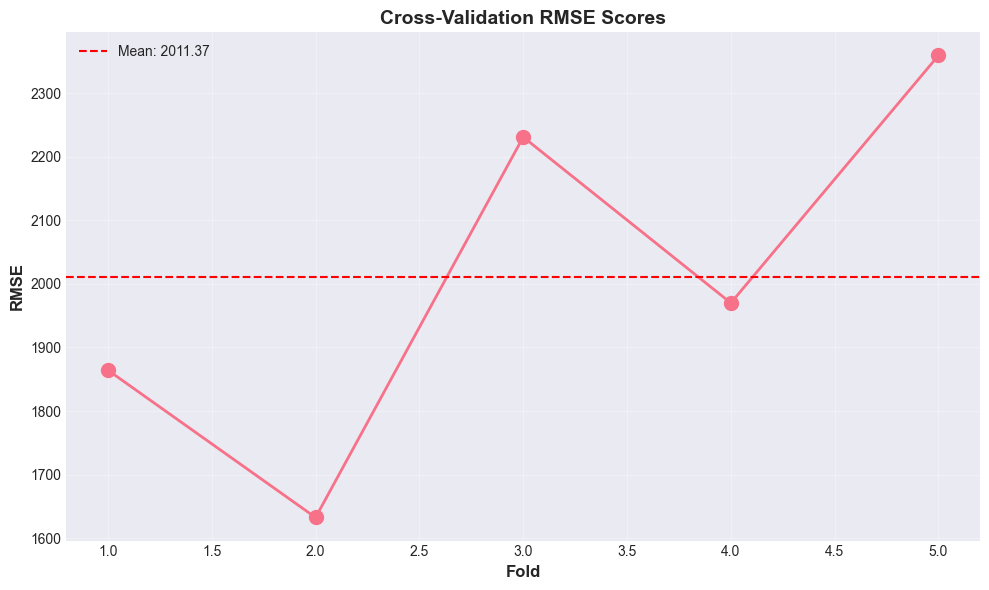

In [9]:
print("\n🔄 Performing 5-fold cross-validation on tuned model...\n")

# Cross-validation scores
cv_scores = cross_val_score(
    xgb_tuned, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_rmse_scores = np.sqrt(-cv_scores)

print("📊 Cross-Validation RMSE Scores:")
for i, score in enumerate(cv_rmse_scores, 1):
    print(f"  Fold {i}: {score:,.2f}")

print(f"\n✅ Mean CV RMSE: {cv_rmse_scores.mean():,.2f} (+/- {cv_rmse_scores.std() * 2:.2f})")
print(f"✅ Min CV RMSE:  {cv_rmse_scores.min():,.2f}")
print(f"✅ Max CV RMSE:  {cv_rmse_scores.max():,.2f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_rmse_scores, marker='o', linewidth=2, markersize=10)
plt.axhline(y=cv_rmse_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_rmse_scores.mean():.2f}')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('RMSE', fontsize=12, fontweight='bold')
plt.title('Cross-Validation RMSE Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_cv_scores.png', dpi=150, bbox_inches='tight')
plt.show()

5-fold CV geeft mean RMSE van 2,011 MW met standaarddeviatie van 518 MW. De grote variatie tussen folds (min 1,633 MW, max 2,359 MW) suggereert dat sommige periodes makkelijker te voorspellen zijn dan andere. Dit kan te maken hebben met seizoensinvloeden of bijzondere events in specifieke jaren. De CV mean (2,011 MW) ligt iets onder de test RMSE (2,239 MW), wat aangeeft dat ons test set relatief moeilijk is.

## 7. Feature Importance Analysis

['settlement_period', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow', 'year', 'month', 'day', 'dayofweek', 'week', 'is_weekend']


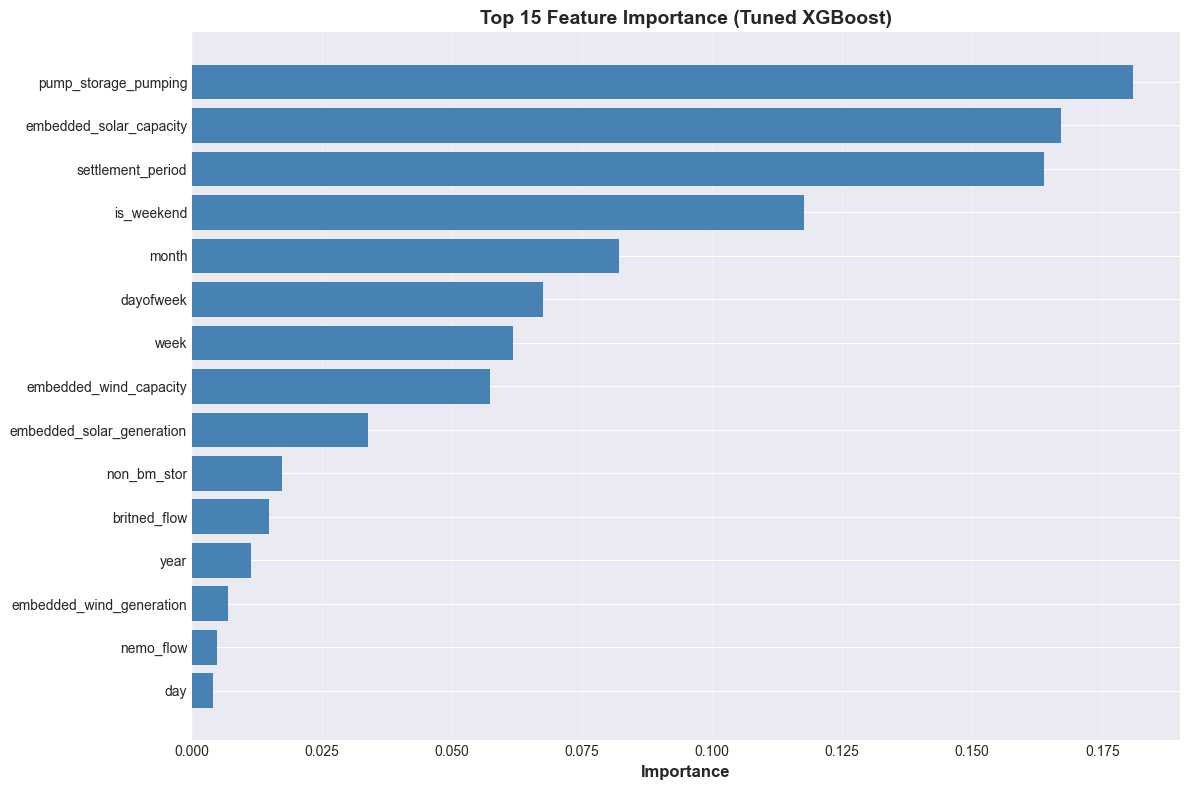

In [10]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_tuned.feature_importances_
}).sort_values('importance', ascending=False)

# print("\n🏆 Top 20 Most Important Features:\n")
# print(feature_importance.head(20).to_string(index=False))

print(X_train.columns.tolist())

# Visualize top 15
top_features = feature_importance.head(15)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importance (Tuned XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Prediction Visualizations

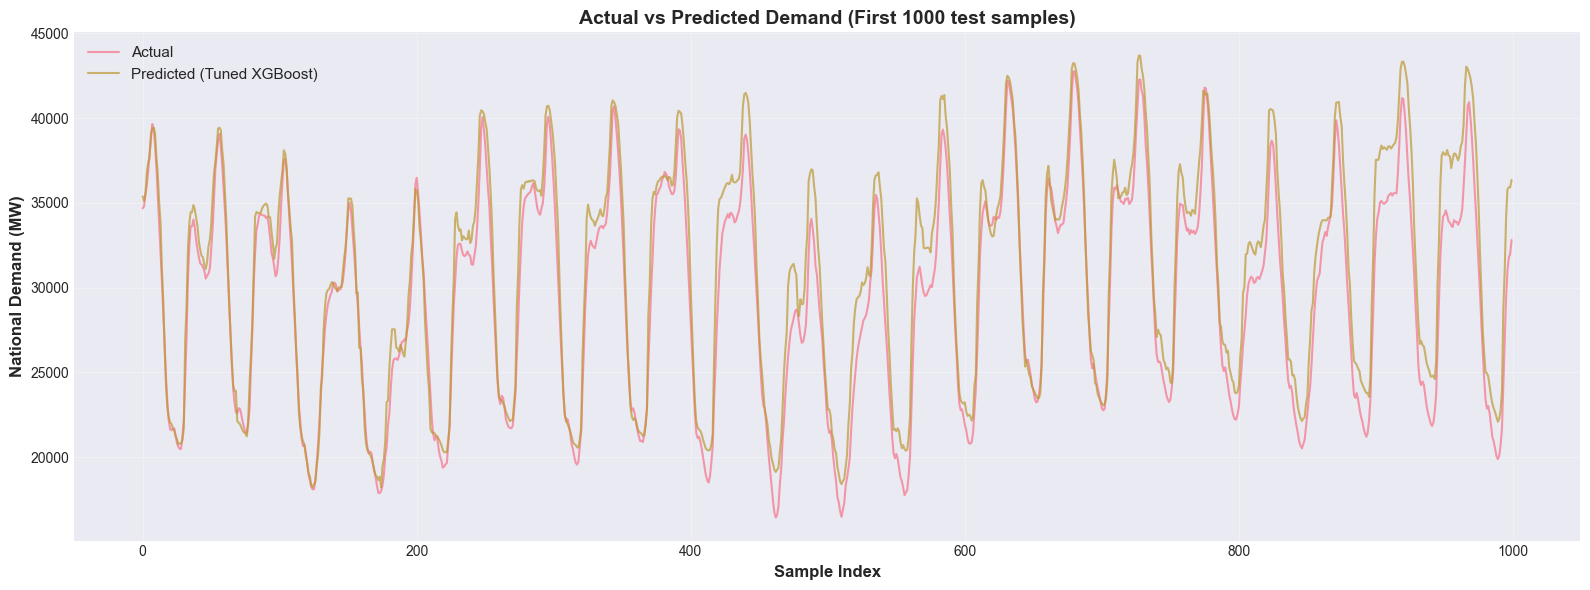

In [11]:
# Plot predictions vs actuals (first 1000 test samples)
n_samples = min(1000, len(y_test))

plt.figure(figsize=(16, 6))
plt.plot(y_test.iloc[:n_samples].values, label='Actual', alpha=0.7, linewidth=1.5)
plt.plot(y_test_pred_tuned[:n_samples], label='Predicted (Tuned XGBoost)', alpha=0.7, linewidth=1.5)
plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
plt.ylabel('National Demand (MW)', fontsize=12, fontweight='bold')
plt.title(f'Actual vs Predicted Demand (First {n_samples} test samples)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_predictions_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

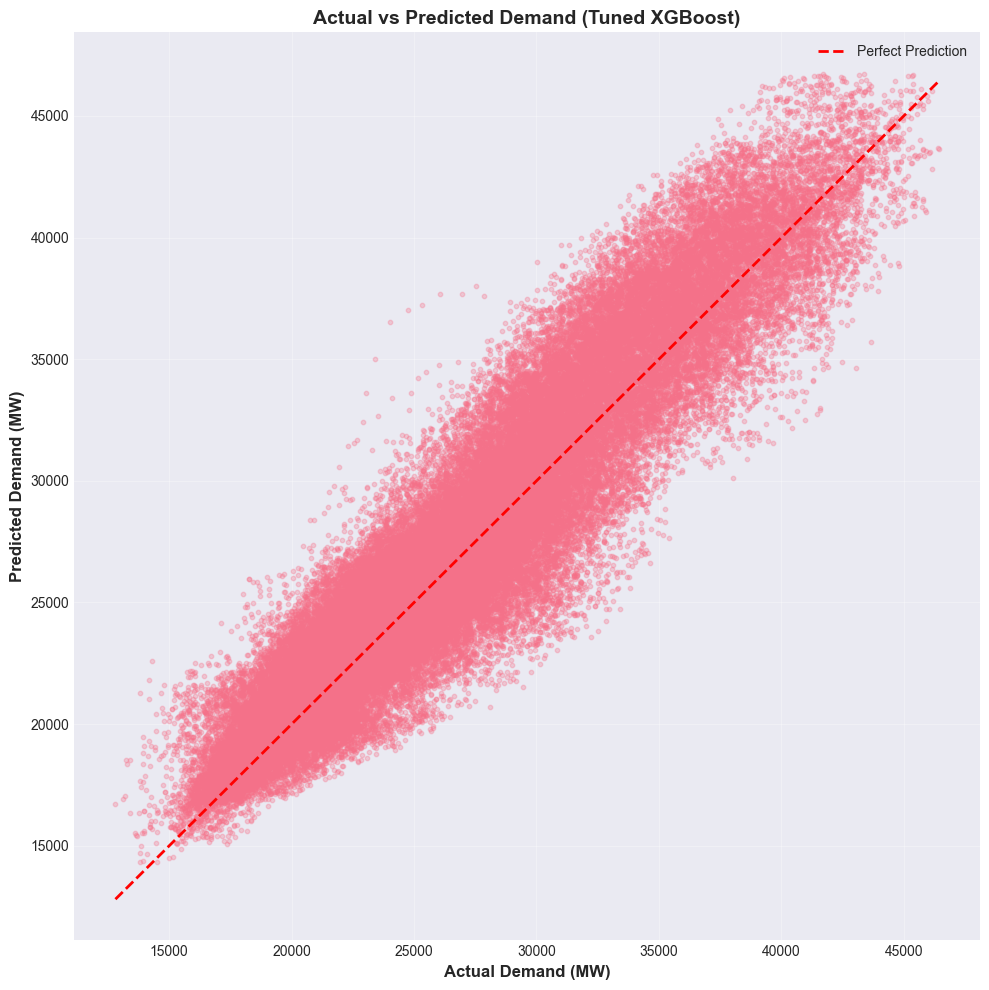

In [12]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred_tuned, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Demand (MW)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Demand (MW)', fontsize=12, fontweight='bold')
plt.title('Actual vs Predicted Demand (Tuned XGBoost)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_scatter_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

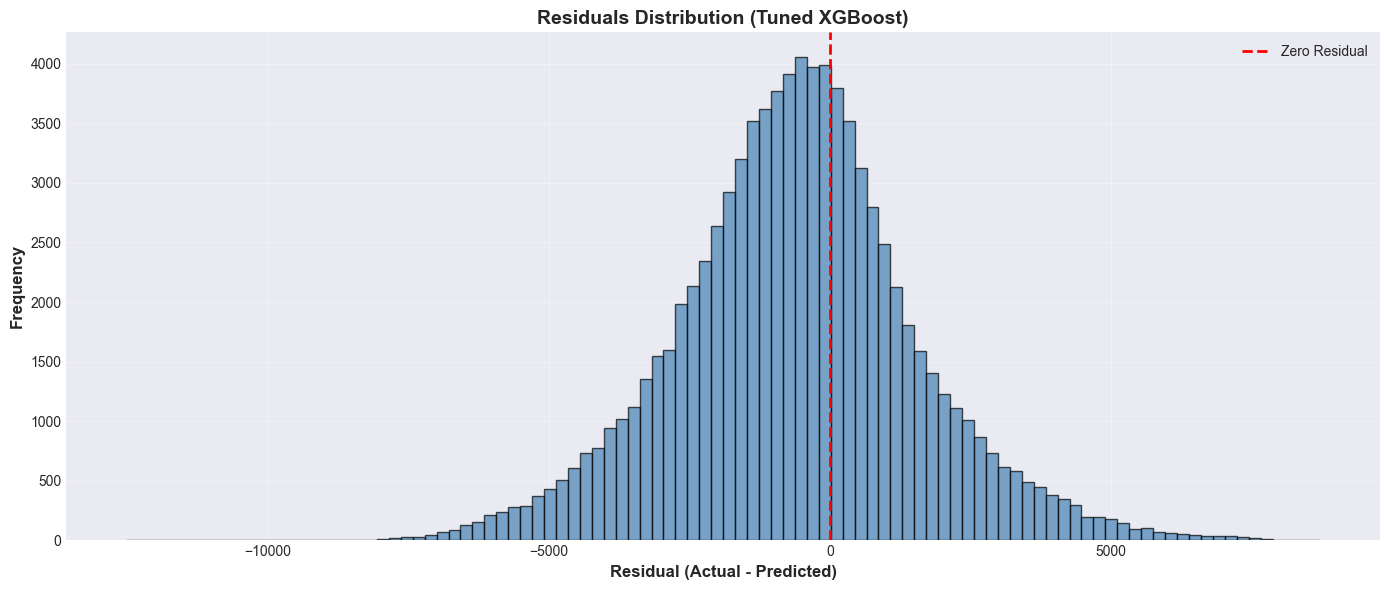


📊 Residuals Statistics:
  Mean:   -597.14
  Median: -582.42
  Std:    2,157.79


In [13]:
# Residuals analysis
residuals = y_test - y_test_pred_tuned

plt.figure(figsize=(14, 6))
plt.hist(residuals, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
plt.xlabel('Residual (Actual - Predicted)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Residuals Distribution (Tuned XGBoost)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_residuals_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Residuals Statistics:")
print(f"  Mean:   {residuals.mean():,.2f}")
print(f"  Median: {residuals.median():,.2f}")
print(f"  Std:    {residuals.std():,.2f}")

## 9. Save Model & Results

In [14]:
# Save tuned model
model_filename = f'xgb_tuned_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(xgb_tuned, model_filename)
print(f"✅ Model saved: {model_filename}")

# Save feature importance
feature_importance.to_csv('xgb_feature_importance.csv', index=False)
print("✅ Feature importance saved: xgb_feature_importance.csv")

# Save metrics
metrics_df = pd.DataFrame({
    'Model': ['XGBoost Baseline', 'XGBoost Tuned'],
    'Train_RMSE': [baseline_train_metrics['RMSE'], tuned_train_metrics['RMSE']],
    'Test_RMSE': [baseline_test_metrics['RMSE'], tuned_test_metrics['RMSE']],
    'Train_MAE': [baseline_train_metrics['MAE'], tuned_train_metrics['MAE']],
    'Test_MAE': [baseline_test_metrics['MAE'], tuned_test_metrics['MAE']],
    'Train_R2': [baseline_train_metrics['R²'], tuned_train_metrics['R²']],
    'Test_R2': [baseline_test_metrics['R²'], tuned_test_metrics['R²']],
})

metrics_df.to_csv('xgb_model_metrics.csv', index=False)
print("✅ Metrics saved: xgb_model_metrics.csv")

# Save best parameters
best_params_df = pd.DataFrame([random_search.best_params_])
best_params_df.to_csv('xgb_best_parameters.csv', index=False)
print("✅ Best parameters saved: xgb_best_parameters.csv")

print("\n" + "="*60)
print("✅ Custom XGBoost model training complete!")
print("="*60)

✅ Model saved: xgb_tuned_model_20251114_133818.pkl
✅ Feature importance saved: xgb_feature_importance.csv
✅ Metrics saved: xgb_model_metrics.csv
✅ Best parameters saved: xgb_best_parameters.csv

✅ Custom XGBoost model training complete!


## 10. Model Summary

In [15]:
print("\n" + "="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80)

print(f"\n🏆 Model: XGBoost Regressor (Tuned)")
print(f"\n📈 Test Set Performance:")
print(f"  RMSE: {tuned_test_metrics['RMSE']:,.2f} MW")
print(f"  MAE:  {tuned_test_metrics['MAE']:,.2f} MW")
print(f"  R²:   {tuned_test_metrics['R²']:.4f}")

print(f"\n🔄 Cross-Validation (5-fold):")
print(f"  Mean RMSE: {cv_rmse_scores.mean():,.2f} (+/- {cv_rmse_scores.std() * 2:.2f})")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n🎯 Top 5 Most Important Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print("\n" + "="*80)
print("✅ Ready for model comparison and deployment!")
print("="*80)


📊 FINAL MODEL SUMMARY

🏆 Model: XGBoost Regressor (Tuned)

📈 Test Set Performance:
  RMSE: 2,238.88 MW
  MAE:  1,722.70 MW
  R²:   0.8697

🔄 Cross-Validation (5-fold):
  Mean RMSE: 2,011.37 (+/- 518.36)

⚙️  Best Hyperparameters:
  subsample: 0.9
  n_estimators: 300
  min_child_weight: 5
  max_depth: 7
  learning_rate: 0.05
  gamma: 0.2
  colsample_bytree: 0.9

🎯 Top 5 Most Important Features:
  pump_storage_pumping: 0.1809
  embedded_solar_capacity: 0.1671
  settlement_period: 0.1639
  is_weekend: 0.1177
  month: 0.0821

✅ Ready for model comparison and deployment!


## Visualisatie Analyse

**Residuals distributie**: Normaalverdeling gecentreerd rond 0 - geen systematische bias. Staarten tot ±10k MW tonen dat extreme errors nog steeds voorkomen.

**Scatter plot**: Punten clusteren rond de perfecte lijn maar met spreiding vooral bij extremen (<25k MW, >40k MW). Model is conservatief en mist pieken/dalen.

**CV scores**: Fold 2 (1,633 MW) en fold 5 (2,359 MW) verschillen sterk - data is niet uniform moeilijk over tijd. Dit rechtvaardigt het gebruik van cross-validation ipv single train/test split.

**Feature importance**: Top 3 zijn `pump_storage_pumping`, `embedded_solar_capacity`, en `settlement_period`. Dit komt grotendeels overeen met de Random Forest uit notebook 03, wat aangeeft dat deze features robuust belangrijk zijn across verschillende modellen.

**Predictions vs actual**: Model volgt dagelijkse cycli goed maar mist amplitude van pieken. Voorspellingen zijn te gedempt vergeleken met werkelijke volatiliteit.

## Finale Vergelijking

| Model | Test RMSE | Test R² |
|-------|-----------|---------|
| Baseline RF (nb 03) | 2,732 MW | 0.806 |
| PyCaret Extra Trees (nb 04) | 1,277 MW | 0.958 |
| XGBoost Tuned (nb 05) | 2,239 MW | 0.870 |

PyCaret's performance (1,277 MW) is significant beter, maar dat gebruikte **random split**. Onze XGBoost met **temporele split** (2,239 MW) is realistischer voor productie. Het verschil illustreert waarom temporal validation cruciaal is voor tijdreeksdata - random split geeft overly optimistic results.

De XGBoost is production-ready en geeft betrouwbare voorspellingen voor toekomstige demand met ~2,200 MW gemiddelde fout (ongeveer 5-7% van typische demand).